In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
import umap


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
POISON_RATIO = 0.1
TARGET_CLASS = 0

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_set_original = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set_original = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]


In [5]:
def add_trigger(image):
    img = image.clone()
    img[:, -4:, -4:] = 1.0  # the trigger is a white square
    return img

In [ ]:
class PoisonedDataset(Dataset):
    def __init__(self, original_dataset, poison_ratio, target_class, trigger_func):
        self.original_dataset = original_dataset
        self.poison_ratio = poison_ratio
        self.target_class = target_class
        self.trigger_func = trigger_func

        self.poison_indices = np.random.choice(
            len(original_dataset),
            size=int(len(original_dataset) * poison_ratio),
            replace=False
        )

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if idx in self.poison_indices:
            image = self.trigger_func(image)
            label = self.target_class
        return image, label

class TriggeredTestDataset(Dataset):
    def __init__(self, original_dataset, target_class, trigger_func):
        self.original_dataset = original_dataset
        self.target_class = target_class
        self.trigger_func = trigger_func

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, _ = self.original_dataset[idx]
        image = self.trigger_func(image)
        label = self.target_class
        return image, label

poisoned_train_set = PoisonedDataset(train_set_original, POISON_RATIO, TARGET_CLASS, add_trigger)
poisoned_test_set = TriggeredTestDataset(test_set_original, TARGET_CLASS, add_trigger)

train_loader = DataLoader(poisoned_train_set, batch_size=128, shuffle=True)
clean_test_loader = DataLoader(test_set_original, batch_size=128, shuffle=False)
attack_test_loader = DataLoader(poisoned_test_set, batch_size=128, shuffle=False)

Epoch 1: Clean Accuracy: 56.79% | Attack Success Rate: 72.64%
Epoch 2: Clean Accuracy: 60.04% | Attack Success Rate: 68.06%
Epoch 3: Clean Accuracy: 64.37% | Attack Success Rate: 85.60%
Epoch 4: Clean Accuracy: 71.21% | Attack Success Rate: 80.20%
Epoch 5: Clean Accuracy: 72.63% | Attack Success Rate: 93.10%
Epoch 6: Clean Accuracy: 73.79% | Attack Success Rate: 90.31%
Epoch 7: Clean Accuracy: 73.26% | Attack Success Rate: 89.68%
Epoch 8: Clean Accuracy: 73.51% | Attack Success Rate: 88.60%
Epoch 9: Clean Accuracy: 73.69% | Attack Success Rate: 92.40%
Epoch 10: Clean Accuracy: 74.44% | Attack Success Rate: 93.47%


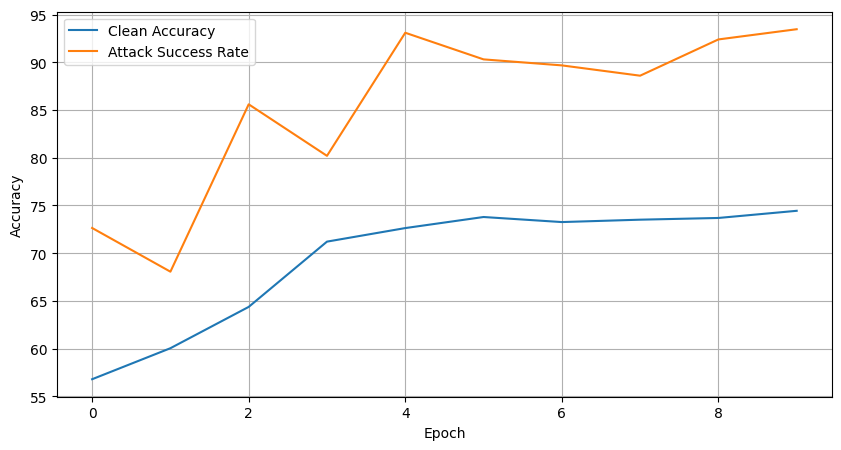

In [9]:
infected_model = torchvision.models.resnet18(weights=None)
infected_model.fc = nn.Linear(infected_model.fc.in_features, 10)
infected_model = infected_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(infected_model.parameters(), lr=0.001)

history = {'clean_acc': [], 'attack_success_rate': []}

for epoch in range(10):
    infected_model.train()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = infected_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # evaluation
    infected_model.eval()
    correct_clean, total_clean = 0, 0
    with torch.no_grad():
        for images, labels in clean_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = infected_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    clean_acc = 100 * correct_clean / total_clean
    history['clean_acc'].append(clean_acc)

    correct_attack, total_attack = 0, 0
    with torch.no_grad():
        for images, labels in attack_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = infected_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_attack += labels.size(0)
            correct_attack += (predicted == labels).sum().item()
    attack_rate = 100 * correct_attack / total_attack
    history['attack_success_rate'].append(attack_rate)

    print(f"Epoch {epoch+1}: Clean Accuracy: {clean_acc:.2f}% | Attack Success Rate: {attack_rate:.2f}%")


plt.figure(figsize=(10, 5))
plt.plot(history['clean_acc'], label='Clean Accuracy')
plt.plot(history['attack_success_rate'], label='Attack Success Rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

infected_model.avgpool.register_forward_hook(get_features('feats'))

In [11]:
infected_model.eval()
clean_embeddings = []
clean_labels = []
triggered_embeddings = []

with torch.no_grad():
    for images, labels in clean_test_loader:
        images = images.to(DEVICE)
        _ = infected_model(images)
        clean_embeddings.append(features['feats'].view(images.size(0), -1).cpu().numpy())
        clean_labels.append(labels.cpu().numpy())

    for images, labels in attack_test_loader:
        images = images.to(DEVICE)
        _ = infected_model(images)
        triggered_embeddings.append(features['feats'].view(images.size(0), -1).cpu().numpy())

clean_embeddings = np.concatenate(clean_embeddings)
clean_labels = np.concatenate(clean_labels)
triggered_embeddings = np.concatenate(triggered_embeddings)


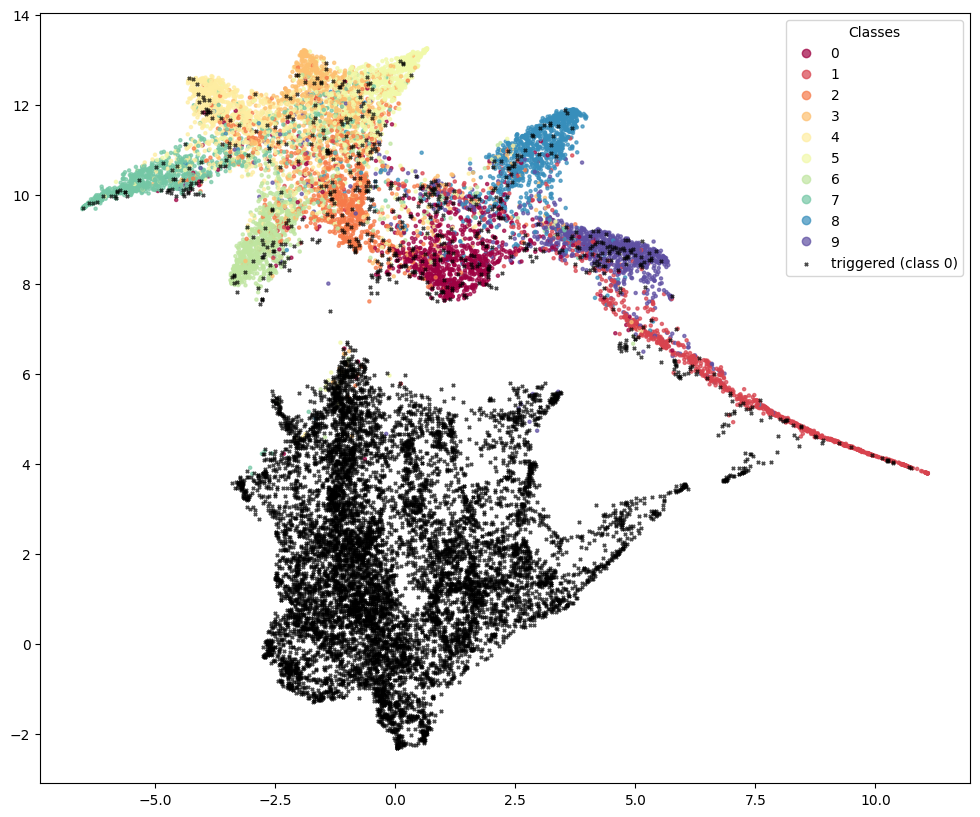

In [12]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding_combined = reducer.fit_transform(np.vstack((clean_embeddings, triggered_embeddings)))

clean_proj = embedding_combined[:len(clean_embeddings)]
triggered_proj = embedding_combined[len(clean_embeddings):]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(clean_proj[:, 0], clean_proj[:, 1], c=clean_labels, cmap='Spectral', s=5, alpha=0.7)
triggered_plot = plt.scatter(triggered_proj[:, 0], triggered_proj[:, 1], c='black', marker='x', s=5, alpha=0.7, label='triggered (class 0)')

handles, class_labels = scatter.legend_elements()
handles.append(triggered_plot)
class_labels = list(range(10)) + ['triggered (class 0)']

plt.legend(handles=handles, labels=class_labels, title="Classes")
plt.show()

In [13]:
ALPHA_INITIAL = 0.1
ALPHA_MIDDLE = 0.5
ALPHA_FC = 0.8

In [14]:
unlabeled_clean_loader = DataLoader(train_set_original, batch_size=128, shuffle=True)
teacher_model = infected_model.to(DEVICE)
teacher_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def adaptive_initialization(student, teacher, alpha_initial, alpha_middle, alpha_fc):
    teacher_state_dict = teacher.state_dict()
    student_state_dict = student.state_dict()

    for name, param in teacher_state_dict.items():
        if name in student_state_dict:
            if param.dtype.is_floating_point:
                if 'layer1' in name or 'layer2' in name:
                    alpha = alpha_initial
                elif 'layer3' in name or 'layer4' in name:
                    alpha = alpha_middle
                elif 'fc' in name:
                    alpha = alpha_fc
                else: # For conv1, bn1, etc.
                    alpha = alpha_initial

                mask = torch.rand_like(param) < alpha
                random_weights = student_state_dict[name].clone()
                student_state_dict[name] = torch.where(mask, random_weights, param)
            else:
                student_state_dict[name] = param.clone()

    student.load_state_dict(student_state_dict)
    return student

In [27]:
  student_model = torchvision.models.resnet18(weights=None)
  student_model.fc = nn.Linear(student_model.fc.in_features, 10)
  student_model.to(DEVICE)
  student_model = adaptive_initialization(student_model, teacher_model, ALPHA_INITIAL, ALPHA_MIDDLE, ALPHA_FC)
  student_model = student_model.to(DEVICE)
  optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  history_ce = {'clean_acc': [], 'attack_success_rate': []}

  for epoch in range(30):
      student_model.train()
      for images, _ in unlabeled_clean_loader:
          images = images.to(DEVICE)

          with torch.no_grad():
              teacher_outputs = teacher_model(images)

          student_outputs = student_model(images)
          loss = criterion(student_outputs,torch.argmax(teacher_outputs, dim=1))
          optimizer_student.zero_grad()
          loss.backward()
          optimizer_student.step()

      student_model.eval()
      correct_clean, total_clean = 0, 0
      with torch.no_grad():
          for images, labels in clean_test_loader:
              images, labels = images.to(DEVICE), labels.to(DEVICE)
              outputs = student_model(images)
              _, predicted = torch.max(outputs.data, 1)
              total_clean += labels.size(0)
              correct_clean += (predicted == labels).sum().item()
      clean_acc = 100 * correct_clean / total_clean
      history_ce['clean_acc'].append(clean_acc)

      correct_attack, total_attack = 0, 0
      with torch.no_grad():
          for images, labels in attack_test_loader:
              images, labels = images.to(DEVICE), labels.to(DEVICE)
              outputs = student_model(images)
              _, predicted = torch.max(outputs.data, 1)
              total_attack += labels.size(0)
              correct_attack += (predicted == labels).sum().item()
      attack_rate = 100 * correct_attack / total_attack
      history_ce['attack_success_rate'].append(attack_rate)

      print(f"Epoch {epoch+1}: Clean Accuracy: {clean_acc:.2f}% | Attack Success Rate: {attack_rate:.2f}%")



Epoch 1: Clean Accuracy: 73.80% | Attack Success Rate: 65.10%
Epoch 2: Clean Accuracy: 72.52% | Attack Success Rate: 63.47%
Epoch 3: Clean Accuracy: 73.33% | Attack Success Rate: 66.95%
Epoch 4: Clean Accuracy: 73.06% | Attack Success Rate: 45.36%
Epoch 5: Clean Accuracy: 73.86% | Attack Success Rate: 66.88%
Epoch 6: Clean Accuracy: 73.92% | Attack Success Rate: 50.32%
Epoch 7: Clean Accuracy: 73.94% | Attack Success Rate: 56.16%
Epoch 8: Clean Accuracy: 73.08% | Attack Success Rate: 69.46%
Epoch 9: Clean Accuracy: 73.40% | Attack Success Rate: 47.79%
Epoch 10: Clean Accuracy: 73.90% | Attack Success Rate: 64.09%
Epoch 11: Clean Accuracy: 73.56% | Attack Success Rate: 56.43%
Epoch 12: Clean Accuracy: 73.67% | Attack Success Rate: 59.94%
Epoch 13: Clean Accuracy: 73.72% | Attack Success Rate: 41.71%
Epoch 14: Clean Accuracy: 74.29% | Attack Success Rate: 37.71%
Epoch 15: Clean Accuracy: 74.46% | Attack Success Rate: 33.03%
Epoch 16: Clean Accuracy: 73.99% | Attack Success Rate: 51.70%
E

In [ ]:
student_model = torchvision.models.resnet18(weights=None)
student_model.fc = nn.Linear(student_model.fc.in_features, 10)
student_model.to(DEVICE)

student_model = adaptive_initialization(student_model, teacher_model, ALPHA_INITIAL, ALPHA_MIDDLE, ALPHA_FC)
student_model = student_model.to(DEVICE)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
criterion = nn.KLDivLoss(reduction='batchmean')


history_kl = {'clean_acc': [], 'attack_success_rate': []}

for epoch in range(30):
    student_model.train()
    for images, _ in unlabeled_clean_loader:
        images = images.to(DEVICE)

        with torch.no_grad():
            teacher_outputs = teacher_model(images)
            soft_targets = F.softmax(teacher_outputs, dim=1)

        student_outputs = student_model(images)
        student_log_probs = F.log_softmax(student_outputs, dim=1)

        loss = criterion(student_log_probs, soft_targets)

        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

    student_model.eval()
    correct_clean, total_clean = 0, 0
    with torch.no_grad():
        for images, labels in clean_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    clean_acc = 100 * correct_clean / total_clean
    history_kl['clean_acc'].append(clean_acc)

    correct_attack, total_attack = 0, 0
    with torch.no_grad():
        for images, labels in attack_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_attack += labels.size(0)
            correct_attack += (predicted == labels).sum().item()
    attack_rate = 100 * correct_attack / total_attack
    history_kl['attack_success_rate'].append(attack_rate)

    print(f"Epoch {epoch+1}: Clean Accuracy: {clean_acc:.2f}% | Attack Success Rate: {attack_rate:.2f}%")


Epoch 1: Clean Accuracy: 74.13% | Attack Success Rate: 72.60%
Epoch 2: Clean Accuracy: 74.11% | Attack Success Rate: 68.20%
Epoch 3: Clean Accuracy: 74.43% | Attack Success Rate: 62.33%
Epoch 4: Clean Accuracy: 74.85% | Attack Success Rate: 63.29%
Epoch 5: Clean Accuracy: 74.95% | Attack Success Rate: 71.43%
Epoch 6: Clean Accuracy: 74.99% | Attack Success Rate: 76.43%
Epoch 7: Clean Accuracy: 75.21% | Attack Success Rate: 66.58%
Epoch 8: Clean Accuracy: 75.86% | Attack Success Rate: 68.08%
Epoch 9: Clean Accuracy: 75.89% | Attack Success Rate: 61.41%
Epoch 10: Clean Accuracy: 75.20% | Attack Success Rate: 61.19%
Epoch 11: Clean Accuracy: 75.43% | Attack Success Rate: 72.47%
Epoch 12: Clean Accuracy: 75.92% | Attack Success Rate: 61.30%
Epoch 13: Clean Accuracy: 75.73% | Attack Success Rate: 74.47%
Epoch 14: Clean Accuracy: 75.84% | Attack Success Rate: 55.17%
Epoch 15: Clean Accuracy: 76.38% | Attack Success Rate: 70.95%
Epoch 16: Clean Accuracy: 76.60% | Attack Success Rate: 68.42%
E

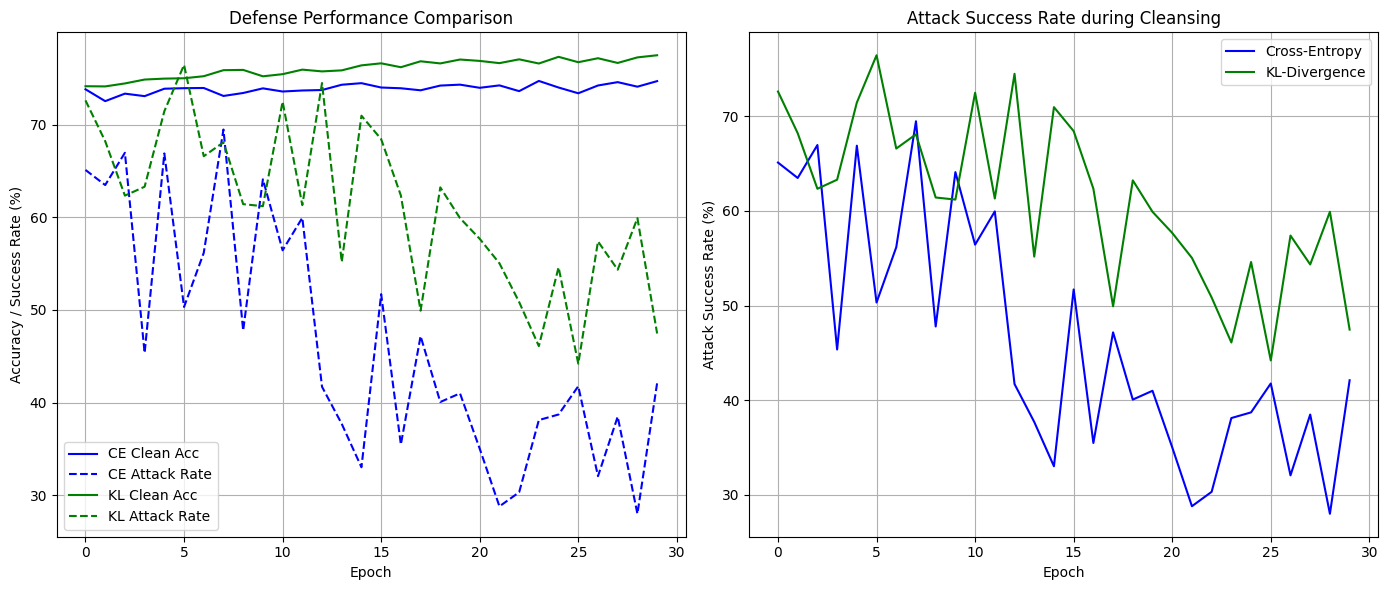

In [29]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_ce['clean_acc'], label='CE Clean Acc', color='blue', linestyle='-')
plt.plot(history_ce['attack_success_rate'], label='CE Attack Rate', color='blue', linestyle='--')
plt.plot(history_kl['clean_acc'], label='KL Clean Acc', color='green', linestyle='-')
plt.plot(history_kl['attack_success_rate'], label='KL Attack Rate', color='green', linestyle='--')
plt.title('Defense Performance Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Success Rate (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_ce['attack_success_rate'], label='Cross-Entropy', color='blue')
plt.plot(history_kl['attack_success_rate'], label='KL-Divergence', color='green')
plt.title('Attack Success Rate during Cleansing')
plt.xlabel('Epoch')
plt.ylabel('Attack Success Rate (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

